# Final Project

Model-Based and Reinforcement Learning Control of the Acrobot

---

### Project Overview

In this final project, you will apply various concepts learned in this course to a **single underactuated dynamic system**: the **Acrobot** (a two-link pendulum with an actuator only at the second joint). This project integrates all the tools explored in the labs, providing a comprehensive comparison between **model-based control** and **learning-based control** approaches.

Specifically, you will:

1. Derive and linearize the **continuous-time dynamics** of the Acrobot.
2. Design **state-feedback** and **LQR** controllers for stabilization.
3. Perform **trajectory generation** (e.g., swing-up trajectory)
4. Perform **trajectory tracking** (via MPC).
5. Implement a **Reinforcement Learning (RL)** controller for the **Gymnasium `Acrobot-v1` environment**.
6. Compare the **model-based** and **RL-based** controllers using common performance metrics.

The final project is individual. You should submit:

- This completed notebook (with code and plots).
- A short written report summarizing methods and results.

---
### Introduction to Acrobot system
The Acrobot is a classic underactuated system. It is a planar two-link robotic arm in the vertical plane (working against gravity), with an actuator at the elbow, but no actuator at the shoulder. The Acrobot is so named because of its resemblance to a gymnast (or acrobat) on a parallel bar, who controls his/her motion predominantly by effort at the waist (and not effort at the wrist). The control goal is typically to swing the Acrobot up from a hanging position to an inverted, balanced position. You may watch a video for the acrobot here.
[Acrobot swing up and stabilization](https://www.youtube.com/watch?v=FeCwtvrD76I). A recent physical AI competition using acrobot can be found here:
[AI Olympics](https://ai-olympics.dfki-bremen.de/)

![Acrobot](https://ai-olympics.dfki-bremen.de/wp-content/uploads/2024/06/video-5.gif)


### System and Tools

- **System:** Acrobot (two-link underactuated pendulum)
- **Model-based control:** `numpy`, `scipy`, `matplotlib`, `python-control` (LQR)
- **Trajectory optimization / MPC:** `python-control`
- **Reinforcement Learning:** `gymnasium` (Acrobot-v1), `stable-baselines3` (PPO)

## Task 0. Setup

Run this cell to import packages and (optionally) install extra dependencies.

In [ ]:
# Install dependencies for Colab
%pip install -q control gymnasium stable-baselines3[extra] scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt

# For numerical integration
try:
    import scipy as sp
    from scipy.integrate import solve_ivp
except ImportError:
    %pip install scipy
    import scipy as sp
    from scipy.integrate import solve_ivp

# For control systems
try:
    import control as ctl
    print(f"control already installed: {ctl.__version__}")
except ImportError:
    %pip install control
    import control as ctl

# For RL APIs
try:
    import gymnasium as gym
    print(f"gymnasium already installed: {gym.__version__}")
except ImportError:
    %pip install gymnasium
    import gymnasium as gym

# For RL algorithms
try:
    import stable_baselines3 as sb3
    print(f"stable_baselines3 already installed: {sb3.__version__}")
except ImportError:
    %pip install stable-baselines3
    import stable_baselines3 as sb3

# For visualization
try:
    import pygame
    print(f"pygame already installed: {pygame.__version__}")
except ImportError:
    %pip install pygame

# Set default plotting style
plt.style.use("ggplot")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 18.3 MB/s eta 0:00:00
control already installed: 0.10.2
gymnasium already installed: 1.2.2


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


stable_baselines3 already installed: 2.7.1
pygame already installed: 2.6.1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_r

## Task 1. Acrobot Dynamics

For this task, we will establish the dynamics model for all the following tasks. Note the solution for this task is provided so that everyone is the on the same page. The system is shown in the following figure

![image.png](https://underactuated.csail.mit.edu/figures/acrobot.svg)

For the system, we define the state as:
$$
x =
\begin{bmatrix}
\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2
\end{bmatrix}^T
$$
where:
- $\theta_1$ is the angle of the first link from the vertical
- $\theta_2$ is the relative angle of the second link with respect to the first
  
The control input is the torque applied at joint 2:
$$
u =\tau \in \mathbb{R}
$$

We have the following constant parameters
- $m_1, m_2$: link masses  
- $l_1$: length of link 1  
- $l_{c1}, l_{c2}$: Center of Mass (COM) distances  
- $I_1, I_2$: moments of inertia  
- $g$: gravity  

The dynamics equation in state-space form can be written as
$$
\dot{x} =
\begin{bmatrix}
\dot{\theta}_1 \\
\dot{\theta}_2 \\
\ddot{\theta}_1 \\
\ddot{\theta}_2
\end{bmatrix}
=
\begin{bmatrix}
\omega_1 \\
\omega_2 \\
-\dfrac{d_2\,\ddot{\theta}_2 + \phi_1}{d_1} \\
\dfrac{
u
+ \frac{d_2}{d_1}\phi_1
- m_2 l_1 l_{c2}\,\omega_1^2\sin\theta_2
- \phi_2
}{
m_2 l_{c2}^2 + I_2 - \frac{d_2^2}{d_1}
}
\end{bmatrix}
$$
where
$$
d_1 =
m_1 l_{c1}^2 +
m_2\left(l_1^2 + l_{c2}^2 + 2\,l_1 l_{c2}\cos \theta_2\right)
+ I_1 + I_2
$$

$$
d_2 =
m_2\left(l_{c2}^2 + l_1 l_{c2}\cos\theta_2\right) + I_2
$$

$$
\phi_2 =
m_2 l_{c2} g \cos(\theta_1 + \theta_2 - \tfrac{\pi}{2})
$$

$$
\phi_1 =
- m_2 l_1 l_{c2}\,\omega_2^2 \sin\theta_2
- 2 m_2 l_1 l_{c2}\,\omega_1\omega_2 \sin\theta_2
+ (m_1 l_{c1} + m_2 l_1) g \cos(\theta_1 - \tfrac{\pi}{2})
+ \phi_2
$$

The system can be implement as follows

In [ ]:
# Example default parameters (you can adjust)
default_params = dict(
    m1=1.0, m2=1.0,
    l1=1.0, l2=1.0,
    lc1=0.5, lc2=0.5,
    I1=1.0, I2=1.0,
    g=9.81
)

def acrobot_dynamics(t, x, u, params):
    """
    Continuous-time Acrobot dynamics:
        x = [theta1, theta2, theta1_dot, theta2_dot]
        u = torque at joint 2 (scalar)
    Returns xdot.
    """
    # Unpack state
    th1, th2, omega1, omega2 = x

    # Unpack parameters
    m1, m2, l1, lc1, lc2, I1, I2, g = (params.get(key) for key in ['m1', 'm2', 'l1', 'lc1', 'lc2', 'I1', 'I2', 'g'])

    # Compute intermediate terms
    d1 = (m1 * lc1**2 +
          m2 * (l1**2 + lc2**2 + 2 * l1 * lc2 * np.cos(th2)) +
          I1 + I2)

    d2 = m2 * (lc2**2 + l1 * lc2 * np.cos(th2)) + I2

    phi2 = m2 * lc2 * g * np.cos(th1 + th2 - np.pi/2)

    phi1 = (-m2 * l1 * lc2 * omega2**2 * np.sin(th2)
            - 2 * m2 * l1 * lc2 * omega1 * omega2 * np.sin(th2)
            + (m1 * lc1 + m2 * l1) * g * np.cos(th1 - np.pi/2)
            + phi2)

    # Compute angular accelerations
    # From the coupled equations, solve for th2_dd first, then th1_dd
    denominator = m2 * lc2**2 + I2 - d2**2 / d1
    th2_dd = (u + (d2 / d1) * phi1
              - m2 * l1 * lc2 * omega1**2 * np.sin(th2)
              - phi2) / denominator

    th1_dd = -(d2 * th2_dd + phi1) / d1

    # Return state derivative
    return np.array([omega1, omega2, th1_dd, th2_dd])

**We can test the dynamics model by simulating it**

- Choose an initial condition, e.g., both links hanging downward with small perturbation.  
- Simulate the passive dynamics (`u = 0`) for a few seconds.  
- Plot $\theta_1(t)$, $\theta_2(t)$ to verify qualitatively that the dynamics look reasonable.

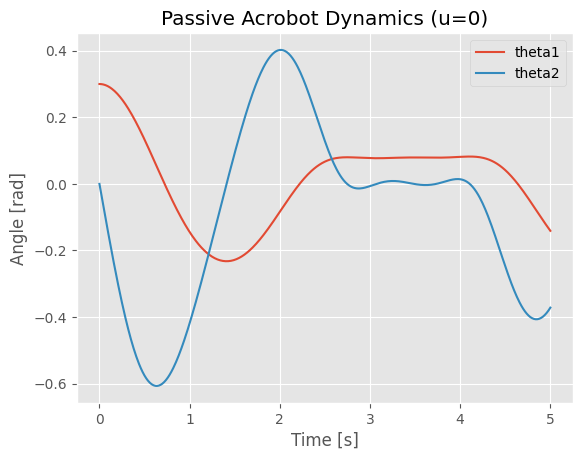

In [ ]:
def simulate_acrobot(x0, u_fun, T=5.0, params=default_params):
    """
    Simulate Acrobot with given input function u_fun(t, x).
    """
    def fwrap(t, x):
        u = u_fun(t, x)
        return acrobot_dynamics(t, x, u, params)

    sol = solve_ivp(fwrap, [0, T], x0, max_step=0.01, rtol=1e-6, atol=1e-8)
    return sol.t, sol.y

# Example usage (uncomment after implementing dynamics):
x0 = np.array([0.3, 0.4, 0.0, 0.0])
t, X = simulate_acrobot(x0, lambda t, x: 0.0) # lambda t, x: 0.0 means u=0
plt.figure()
plt.plot(t, X[0], label="theta1")
plt.plot(t, X[2], label="theta2")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Angle [rad]")
plt.title("Passive Acrobot Dynamics (u=0)")
plt.show()

We can also create animation to show the motion for the system.

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

def animate_acrobot_solution(sol, x0, params=None, duration=5.0):
    """
    Create animation from a solved acrobot ODE solution.

    Parameters:
    sol: Solution object containing time array t and state array y
    x0: Initial state [theta1, theta2, omega1, omega2]
    params: Dictionary of acrobot parameters (uses default_params if None)
    duration: Animation duration (s)

    Returns:
    HTML animation object
    """
    if params is None:
        params = default_params

    l1 = params['l1']
    l2 = params['l2']

    # Set up the figure and axis for animation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Acrobot animation subplot
    total_length = l1 + l2
    ax1.set_xlim(-total_length * 1.2, total_length * 1.2)
    ax1.set_ylim(-total_length * 1.2, total_length * 1.2)
    ax1.set_aspect('equal')
    ax1.set_title(f'Acrobot Animation (θ₁₀={x0[0]:.2f}, θ₂₀={x0[1]:.2f})')
    ax1.grid(True)
    ax1.plot(0, 0, 'ko', markersize=8)  # Fixed pivot point

    # Create acrobot elements
    link1, = ax1.plot([], [], 'b-', linewidth=4, label='Link 1')
    link2, = ax1.plot([], [], 'r-', linewidth=4, label='Link 2')
    joint1, = ax1.plot([], [], 'ko', markersize=8)
    joint2, = ax1.plot([], [], 'go', markersize=10)
    trace, = ax1.plot([], [], 'g--', alpha=0.3, linewidth=1)
    ax1.legend()

    # Time series subplot
    ax2.set_xlim(0, duration)
    ax2.set_ylim(-np.pi, np.pi)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Angle (rad)')
    ax2.set_title('Joint Angles vs Time')
    ax2.grid(True)

    theta1_line, = ax2.plot([], [], 'b-', label='θ₁(t)', linewidth=2)
    theta2_line, = ax2.plot([], [], 'r-', label='θ₂(t)', linewidth=2)
    time_marker1, = ax2.plot([], [], 'bo', markersize=6)
    time_marker2, = ax2.plot([], [], 'ro', markersize=6)
    ax2.legend()

    # Store trace points
    x_trace, y_trace = [], []

    # Animation function
    def animate(frame):
        if frame < len(sol.t):
            # Current state
            theta1 = sol.y[0][frame]
            theta2 = sol.y[1][frame]
            t_current = sol.t[frame]

            # Joint positions
            x1 = l1 * np.sin(theta1)
            y1 = -l1 * np.cos(theta1)
            x2 = x1 + l2 * np.sin(theta1 + theta2)
            y2 = y1 - l2 * np.cos(theta1 + theta2)

            # Update acrobot links
            link1.set_data([0, x1], [0, y1])
            link2.set_data([x1, x2], [y1, y2])
            joint1.set_data([x1], [y1])
            joint2.set_data([x2], [y2])

            # Update trace (last 100 points)
            x_trace.append(x2)
            y_trace.append(y2)
            if len(x_trace) > 100:
                x_trace.pop(0)
                y_trace.pop(0)
            trace.set_data(x_trace, y_trace)

            # Update time series
            theta1_line.set_data(sol.t[:frame+1], sol.y[0][:frame+1])
            theta2_line.set_data(sol.t[:frame+1], sol.y[1][:frame+1])
            time_marker1.set_data([t_current], [theta1])
            time_marker2.set_data([t_current], [theta2])

        return link1, link2, joint1, joint2, trace, theta1_line, theta2_line, time_marker1, time_marker2

    # Create and display animation
    anim = FuncAnimation(fig, animate, frames=len(sol.t), interval=50, blit=True, repeat=True)
    plt.tight_layout()
    plt.show()

    # Return HTML version for display
    return HTML(anim.to_jshtml())

# Create solution object from existing variables
from types import SimpleNamespace
solution = SimpleNamespace(t=t, y=X)

print(f"Animating acrobot with initial state: θ₁={x0[0]:.2f}, θ₂={x0[1]:.2f}, ω₁={x0[2]:.2f}, ω₂={x0[3]:.2f}")
print(f"Solution contains {len(solution.t)} time points over {solution.t[-1]:.2f} seconds")

# Create and display animation
print("Creating animation...")
animation_html = animate_acrobot_solution(solution, x0, default_params, duration=t[-1])
display(animation_html)

Output hidden; open in https://colab.research.google.com to view.

## Task 2. Linearization and LQR Design (20 pts)

With the dynamics model, we can design controllers for the Acrobot. In this task, you need to:

1. Choose an equilibrium point for the system to stabilize (e.g., the **upright configuration**).  
2. Linearize the dynamics about that equilibrium to obtain:  $\dot{x} = A x + B u $
3. Design an **LQR controller**: $   u = -Kx $
4. Simulate the closed-loop system and analyze performance (settling time, energy, etc.).

### Task 2.1 – Equilibrium Point (5 pts)

For the Acrobot system, one important equilibrium point is the **upright configuration**:
$$
x_{eq} = [\pi, 0, 0, 0]^T
$$
This corresponds to:
- $\theta_1 = \pi$ (first link pointing upward)
- $\theta_2 = 0$ (second link aligned with first link)  
- $\dot{\theta}_1 = 0$ (no angular velocity)
- $\dot{\theta}_2 = 0$ (no angular velocity)

**Answer the following questions** in your project report:

1. **Verification**: Show that $x_{eq} = [\pi, 0, 0, 0]^T$ is indeed an equilibrium point by verifying that $\dot{x} = 0$ when $x = x_{eq}$.

2. **Equilibrium Input**: Calculate the corresponding equilibrium control input $u_{eq}$ (torque at joint 2) required to maintain this upright configuration.

### Task 2.2 – Linearization around the equilibrium point (5 pts)

We will use the `Python Control` library to linearize the system around $x_{eq}$ and $u_{eq}$. First create the nonlinear system object using `ctl.nlsys` in the python control library, then use `linearize` to linearize the system.

In the code below, you need to:
- Complete the `acrobot_update` function by calling `acrobot_dynamics` with the correct inputs (note that `u` will be a 1-element array)
- Complete the `acrobot_output` function to return the full state vector as output
- The linearization will then be performed automatically around the specified equilibrium point

After linearization, you will obtain the linear system matrices $A$ and $B$ such that:
$$\dot{x} = A(x - x_{eq}) + B(u - u_{eq})$$

Print out the $A$ and $B$ matrices for the linearized system and put this into your project report.

In [ ]:
# Use the default parameters defined earlier for the Acrobot model
acrobot_params = default_params

# State derivative function for python-control
def acrobot_update(t, x, u, params):
    """
    Wrapper for the acrobot_dynamics function to be used with control.nlsys.
    The input 'u' from nlsys is an array, so we extract the scalar torque.
    """
    # TODO: Call the acrobot_dynamics function with the correct inputs.

# Output function for python-control
def acrobot_output(t, x, u, params):
    """
    Defines the system output. For state-feedback control, we assume we have the full state as the output.
    """
    # TODO: Return the state vector as the output.


# Create the nonlinear system object using nlsys
acrobot_nlsys = ctl.nlsys(
    acrobot_update,
    acrobot_output,
    name='acrobot',
    params=acrobot_params,
    states=['theta1', 'theta2', 'omega1', 'omega2'],
    outputs=['theta1', 'theta2', 'omega1', 'omega2'],
    inputs=['tau']
)

# After filling in the TODOs, linearize the system using acrobot_nlsys.linearize
# TODO: linearize the system at the upright equilibrium point

### Task 2.3 – LQR Controller Design for the Linearized System (10 pts)

For this task, you will design an LQR controller to stabilize the Acrobot around the upright configuration by completing the following steps:

**Step 1: Check System Controllability**
- Compute the controllability matrix using `ctl.ctrb(A, B)`
- Check if the system is controllable by verifying that the rank equals the number of states (4)

**Step 2: Design LQR Controller**
- Choose appropriate LQR weight matrices $Q_x$ (4×4) and $Q_u$ (1×1)
  - $Q_x$ penalizes state deviations from equilibrium
  - $Q_u$ penalizes control effort
- Use `ctl.lqr(A, B, Qx, Qu)` to compute the feedback gain matrix $K$
- The resulting controller will be: $u = -K (x - x_{\text{eq}}) + u_{\text{eq}}$

**Step 3: Simulate Closed-Loop System**
Test your LQR controller with two initial conditions near the upright equilibrium:
- $x_0 = [19\pi/20, \pi/10, 0, 0]^T$
- $x_0 = [9\pi/10, \pi/5, 0, 0]^T$

For each initial condition, create plots showing:
1. All four state trajectories vs time: $\theta_1(t)$, $\theta_2(t)$, $\dot{\theta}_1(t)$, $\dot{\theta}_2(t)$
2. Control input vs time: $u(t)$

**Step 4: Performance Evaluation**
Analyze your results by addressing:
- Does the controller successfully stabilize both initial conditions?
- What is the approximate settling time for each state?
- How does changing the weight matrices $Q_x$ and $Q_u$ affect performance? Try at least two different weight combinations and compare the results

In [ ]:
# TODO: choose equilibrium and design LQR


## Task 3. Trajectory Generation and Tracking (30 pts)

Task 2 only stabilizes the Acrobot around the upright configuration. But what if the Acrobot is initially pointing downward? In this task, you will design controllers to swing the Acrobot up from the downward position to the upright position. Specifically, you will:

1. Define a **swing-up task** for the Acrobot (e.g., from downward configuration to upright).  
2. Generate an optimal trajectory from downward configuration to upright (refer to Lab 7).
3. Design an MPC controller to track the generated optimal trajectory (refer to Lab 8)
4. Simulate the resulting **trajectory tracking control** on the nonlinear system.

### Task 3.1 – Optimal Trajectory Generation (10 pts)

Generate and plot the optimal trajectory using `solve_ocp` for the followint case
- **Input cost with terminal constraint:**
   $$
   \min_{u(\cdot)} \int_0^T (u(\tau) - u_f)^T Q_u (u(\tau) - u_f)\, d\tau
   $$
   subject to $x(T) = x_f$
Also consider the constraint on the control input $|u| \leq 5$ Nm.

After generating the optimal trajectory, you need to **simluate the system** using the optimal control inputs and make sure that the system will behave accordingly, i.e., it will actually swing up.

In [ ]:
# TODO: write your code here for the optimal trajecotry generation

### Task 3.2 – Trajectory Tracking (20 pts)

For this task, you need to track the optimal trajectory $(x_d(t), u_d(t))$ you have generated in Task 3.1 using a continuous-time Model Predictive Controller (MPC). The controller will solve a finite-horizon optimal control problem at each time step to find a corrective input $\delta u(t)$ that minimizes deviations from the reference trajectory. The total control applied to the system is:
$$
u(t) = u_d(t) + \delta u(t)
$$

This requires defining an **error system** where the state is the tracking error $e(t) = x(t) - x_d(t)$ and the input is the control error $\delta u(t)$. The dynamics of this error system can be expressed as:
$$
\dot{e}(t) = f(x_d(t) + e(t), u_d(t) + \delta u(t)) - f(x_d(t), u_d(t))
$$
where $f$ represents the nonlinear Acrobot dynamics.

To implement the MPC tracker, you will:
1.  Create interpolants for your reference trajectory, $x_d(t)$ and $u_d(t)$, using the results from Task 3.1.
2.  Define the error dynamics as a new nonlinear system (e.g., `acrobot_err_update`). The Python code in the next cell provides a template for this.
3.  Define a quadratic cost function for the MPC that penalizes the error state $e(t)$ and the error input $\delta u(t)$ over a prediction horizon $T_h$:
    - Trajectory cost: $\int_0^{T_h} (e(\tau)^T Q_x e(\tau) + \delta u(\tau)^T Q_u \delta u(\tau)) \, d\tau$.
    - Terminal cost: $e(T_h)^T P e(T_h)$.
4.  Define input constraints on the total control input, $|u(t)| \le u_{\max}= 5$ Nm. Since $u(t) = u_d(t) + \delta u(t)$, the constraints on the MPC's decision variable $\delta u(t)$ become time-varying:
    $$
    -u_{\max} - u_d(t) \le \delta u(t) \le u_{\max} - u_d(t)
    $$
5.  Create an `OptimalControlProblem` for the error system using the tracking cost and time-varying input constraints.
6.  Implement an MPC simulation loop that, at each time step:
    - Calculates the current error $e(t) = x(t) - x_d(t)$.
    - Updates the input constraints for the OCP based on the current reference input $u_d(t)$.
    - Solves the OCP to get an optimal error input trajectory $\delta u(\tau)$ for the next $T_h$ seconds.
    - Applies the first segment of the total control input $u(t) = u_d(t) + \delta u(t)$ to the true nonlinear Acrobot system.
    - Simulates the system forward for a short duration and repeats the process.

In [ ]:
def acrobot_err_update(t, e, du, params):
    # e: error state (4,)
    # du: error input (1,)  (delta torque)
    xref = params['x_ref'](t).ravel()    # x_ref(t)
    uref = params['u_ref'](t).ravel()[0] # scalar
    x_tot = xref + e
    u_tot = uref + du[0]

    # total and reference dynamics
    f_tot = acrobot_dynamics(t, x_tot, u_tot, params['plant_params'])
    f_ref = acrobot_dynamics(t, xref, uref, params['plant_params'])

    return f_tot - f_ref    # error dynamics


acrobot_err = ctl.nlsys(
    acrobot_err_update, None, name="acrobot_err",
    inputs=('du',),
    outputs=('e1','e2','e3','e4'),
    states=('e1','e2','e3','e4'),
    params={
        'x_ref': x_d,
        'u_ref': u_d,
        'plant_params': plant_params
    }
)

# TODO: design MPC controller for trajectory tracking using acrobot_err system

## Task 4: Swing Up and then Stay (20 pts)

In this task, you will combine your optimal swing-up trajectory and tracking controller (from Task 3) with your LQR stabilization controller around the upright (from Task 2) to build a **hybrid controller** that:

1. Uses the trajectory-tracking controller to swing the Acrobot up from the downward position
2. Automatically switches to the LQR controller when the Acrobot gets close to the upright position
3. Maintains balance around the upright equilibrium using LQR control

### Hybrid Control Strategy

The hybrid controller operates as a state machine with two modes:

- **Swing-up Mode**: When the Acrobot is far from upright, use your MPC trajectory tracking controller from Task 3
- **Stabilization Mode**: When the Acrobot is near upright, switch to your LQR controller from Task 2

### Implementation Requirements

You need to implement the following components:

1. **Controller Functions** (adapt from your previous tasks):
    - `u_track(x, t)`: Your trajectory tracking controller from Task 3
    - `u_lqr(x)`: Your LQR controller from Task 2: $u = -K(x - x_{eq}) + u_{eq}$

2. **Switching Logic Functions**:
    - `should_switch_to_lqr(x)`: Returns `True` when state is close enough to upright to switch to LQR
    - `should_switch_to_swingup(x)`: Returns `True` when state has drifted too far from upright (optional)

3. **Region Detection**: Use the provided `in_upright_region(x)` function (see next cell) which defines a "capture region" around the upright equilibrium based on:
    - Angular position tolerances: $|\theta_1 - \pi| < 0.25$ rad, $|\theta_2| < 0.5$ rad
    - Angular velocity limits: $|\dot{\theta}_1| < 1.0$ rad/s, $|\dot{\theta}_2| < 1.0$ rad/s

### Tasks to Complete:

1. **Implement the hybrid controller** using the template in the code cells below
2. **Test the controller** starting from the downward hanging position: $x_0 = [0, 0, 0, 0]$
3. **Simulate and plot**:
    - State trajectories showing the swing-up and stabilization phases
    - Control input over time
    - Mode switching events
4. **Evaluate performance**:
    - Does it successfully swing up and stabilize?
    - How smooth is the transition between controllers?
    - What is the total time to reach and stabilize at upright?

The code framework is provided in the following cells to help you get started.

In [ ]:
def wrap_angle(angle):
    """Wrap angle to [-pi, pi)."""
    return (angle + np.pi) % (2*np.pi) - np.pi

# Thresholds for upright region, you can change them as needed
th1_thresh = 0.25   # rad (~14 deg) around pi
th2_thresh = 0.5    # rad (~29 deg) around 0
w1_thresh  = 1.0    # rad/s
w2_thresh  = 1.0    # rad/s

# function to check if state is in upright region
def in_upright_region(x):
    th1, th2, th1d, th2d = x
    e_th1 = wrap_angle(th1 - np.pi)
    e_th2 = wrap_angle(th2 - 0.0)

    cond_angle = (abs(e_th1) < th1_thresh) and (abs(e_th2) < th2_thresh) # check angles
    cond_vel   = (abs(th1d) < w1_thresh) and (abs(th2d) < w2_thresh) # check angular velocities

    return cond_angle and cond_vel

In [ ]:
u_max = 5.0   # input limit for safety
mode  = "swingup"   # initial mode

def hybrid_controller(x, t):
    global mode

    if mode == "swingup":
        # 1) Use your trajectory-tracking controller (OCP/MPC/PD+FF)
        u = u_track(x, t)

        # 2) Check if we can switch to LQR
        if should_switch_to_lqr(x):
            mode = "stabilize"

    elif mode == "stabilize":
        # 1) Use LQR controller around upright
        u = u_lqr(x)

        # 2) Optionally: if we drift too far → go back to swing-up
        if should_switch_to_swingup(x):
            mode = "swingup"

    else:
        raise ValueError("Unknown mode: " + mode)

    # Saturate the torque for safety
    u = float(np.clip(u, -u_max, u_max))
    return u

## Task 5. Reinforcement Learning Control (25 pts)

Tasks 2 to 4 are based on model-based optimization and control to swing-up and balance the Acrobot. Another way to do it is to use RL. In this task, you will:

1. Use the **Gymnasium** `Acrobot-v1` environment.  
2. Implement and train an RL agent (e.g., **PPO** algorithm from `stable-baselines3`).  
3. Evaluate the trained policy: success rate, episode reward, qualitative behavior.

The `Acrobot-v1` [environment](https://gymnasium.farama.org/environments/classic_control/acrobot/) has different characteristics compared to the continuous control problem in previous tasks:

**Environment Settings:**
- **Actions**: 3 discrete actions (torque -1, 0, +1) vs. continuous torque in Tasks 1-4
- **Reward structure**: -1 per time step (encourages faster completion) vs. quadratic costs in optimal control
- **Success criterion**: End-effector height > 1.0 (approximately upright) vs. exact state targets
- **Episode termination**: Success OR maximum 500 steps vs. fixed time horizons
- **No input penalties**: Unlike LQR/MPC which penalize control effort
- **Stochastic initial conditions**: Random start states vs. deterministic initial conditions

**Key Differences from Model-Based Control:**
- **Objective**: Minimize episode length (maximize reward) vs. minimize quadratic cost functionals
- **Action space**: Discrete bang-bang control vs. smooth continuous control
- **Learning approach**: Trial-and-error policy optimization vs. analytical/numerical optimal control
- **Robustness**: Trained on distribution of initial states vs. designed for specific operating points

The following code cells demonstrate how to get a RL policy for the **default** `Acrobot-v1` environment.
1. **Create Environment**: Set up the Gymnasium `Acrobot-v1` environment with appropriate observation and action spaces
2. **Train RL Agent**: Use PPO from stable-baselines3 to learn a policy through interaction with the environment
3. **Evaluate Performance**: Test the trained model on multiple episodes to assess success rate and behavior
4. **Visualize Results**: Render the learned policy in action to qualitatively evaluate the swing-up strategy

In [ ]:
# Create and inspect the Gymnasium Acrobot environment
env = gym.make("Acrobot-v1", render_mode=None)
obs, info = env.reset()
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Initial observation:", obs)

env.close()

After create the environement, we can train the model using PPO algorithm from stable baseline3 (you may modify hyperparameters, total timesteps, etc.):

In [ ]:
from stable_baselines3 import PPO
import numpy as np
from stable_baselines3.common.evaluation import evaluate_policy

# Use the wrapper
env = gym.make("Acrobot-v1")
model = PPO("MlpPolicy", env, verbose=1) # Create PPO model instance
model.learn(total_timesteps=200_000) # Train for 200,000 timesteps

# Save model
model.save("ppo_acrobot") # this will save the trained model to a zip file

# Evaluate
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward over 20 eval episodes: {mean_reward:.2f} ± {std_reward:.2f}")

env.close()

After that, we can evaluate and visualize the trained policy performance. The code below demonstrates the trained PPO agent in action by running several episodes with visual rendering enabled. This allows us to see how the agent swings up the acrobot. The visualization helps validate that the training was successful and provides intuition about the RL controller's behavior.

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from IPython.display import Video

# Create a vectorized environment for video recording
def make_env():
    return gym.make("Acrobot-v1", render_mode="rgb_array")

env = DummyVecEnv([make_env])

# Wrap with video recorder
env = VecVideoRecorder(
    env,
    "videos/",
    record_video_trigger=lambda x: x == 0,  # Record first episode
    video_length=500,  # Maximum video length
    name_prefix="acrobot_ppo"
)

# Load the trained model
model = PPO.load("ppo_acrobot")

# Run one episode with video recording
obs = env.reset()
for _ in range(500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    if done[0]:
        break

env.close()

# Display the recorded video
Video("videos/acrobot_ppo-step-0-to-step-500.mp4", width=600)

### Task 5.1 – Evaluation and Analysis for default Gymnasium `Acrobot-v1` environment  (5 pts)

After training your PPO agent, you need to analyze its behavior and performance. Run the evaluation code above and then address the following questions:

**Questions to Answer:**

1. **State Trajectory Analysis**: Plot the joint angles $\theta_1(t)$ and $\theta_2(t)$ with respect to time for several episodes. What patterns do you observe in the learned policy's swing-up strategy?

2. **Tip Height Analysis**: Plot the tip's height with respect to time. The tip height can be calculated as: `height = -cos(θ₁) - cos(θ₁ + θ₂)`.

![tip height](https://gymnasium.farama.org/_images/acrobot.gif)

You should notice that the acrobot swings up but doesn't get to the upright position (θ₁ = π, θ₂ = 0). Instead, it typically terminates the episode once the tip height exceeds 1.0.  This is because the default Gymnasium `Acrobot-v1` environment has a **sparse reward structure** that differs significantly from optimal control formulations:

- **Termination condition**: Episode ends when tip height > 1.0
- **Reward signal**: -1 per time step (encourages faster completion)
- **No balancing phase**: Once the success condition is met, the episode terminates immediately

This means the RL agent learns to **Swing up quickly** to minimize the negative reward accumulation, **reach the target height** as fast as possible, and it does **not learn balancing behavior** since the episode ends upon reaching the goal. This is fundamentally different from the model-based controllers you designed in Tasks 2-4, which were formulated to both reach AND maintain the upright equilibrium. The RL agent essentially learns only the "swing-up phase" without the "stabilization phase." This difference highlights an important consideration in RL problem formulation: the reward structure directly shapes the learned behavior. To make the acrobot fully upright, you would need to modify the environment with different rewards.

### Task 5.2 – Train a Stablization Policy (5 pts)

Now we can try to revise the default setting to make it similar to model-based approach. To do this, we will do two things through the wrapper of gym:

- Convert the problem to be continuous
- Use a new reward function similar to the cost function we have used in trajectory optimization

**What is a Gym [Wrapper](https://gymnasium.farama.org/introduction/basic_usage/#modifying-the-environment)?**

A wrapper is a design pattern that allows us to modify the behavior of an existing environment without creating an entirely new one from scratch. Wrappers "wrap around" the original environment and can modify:
- Action spaces (discrete → continuous)
- Observation spaces
- Reward functions
- Episode termination conditions
- Any other environment behavior

**Why Use Wrappers Instead of Creating New Environments?**
1. **Reusability**: We can apply the same modifications to different base environments
2. **Modularity**: Each wrapper handles one specific modification, making code more organized
3. **Maintainability**: Changes to the base environment automatically propagate to wrapped versions
4. **Efficiency**: We leverage the existing, well-tested Gymnasium implementation rather than reimplementing dynamics

In our case, we'll use two wrappers:
- `ContinuousAcrobotActionWrapper`: Converts discrete actions {-1, 0, +1} to continuous torque values
- `AcrobotOCPRewardWrapper`: Replaces the sparse -1 reward with a customized reward similar to optimal control

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

# Action wrapper to convert discrete actions to continuous torque
class ContinuousAcrobotActionWrapper(gym.Wrapper):
    """
    Convert discrete Acrobot-v1 actions into continuous torque in [-torque_limit, torque_limit].
    The underlying env is still Acrobot-v1, but we override the torque used in the dynamics.
    """
    def __init__(self, env, torque_limit=5.0):
        super().__init__(env)
        self.torque_limit = float(torque_limit)
        # Continuous 1-D action: torque in [-torque_limit, torque_limit]
        self.action_space = spaces.Box(
            low=np.array([-self.torque_limit], dtype=np.float32),
            high=np.array([self.torque_limit], dtype=np.float32),
            dtype=np.float32,
        )
        # for reward wrapper
        self.unwrapped.last_u = 0.0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.unwrapped.last_u = 0.0
        return obs, info

    def step(self, action):
        # action is expected to be a 1D array or scalar; clip to [-torque_limit, torque_limit]
        if isinstance(action, np.ndarray):
            u = float(action.squeeze())
        else:
            u = float(action)
        u = np.clip(u, -self.torque_limit, self.torque_limit)
        self.unwrapped.last_u = u

        # Hack: temporarily set AVAIL_TORQUE so that super().step(1) uses our u
        orig_avail = self.env.unwrapped.AVAIL_TORQUE.copy()
        self.env.unwrapped.AVAIL_TORQUE[:] = [u, u, u]

        # Use middle index (1) – all entries are the same anyway
        obs, reward, terminated, truncated, info = self.env.step(1)

        # Restore original discrete torque set
        self.env.unwrapped.AVAIL_TORQUE[:] = orig_avail

        return obs, reward, terminated, truncated, info

# Reward wrapper to implement OCP-like reward
class AcrobotOCPRewardWrapper(gym.Wrapper):
    """
    Replace Acrobot reward by r = -u^T Q_u u + height reward + terminal bonus (on success).
    Assumes the wrapped env sets env.unwrapped.last_u to the actual torque used.
    """
    def __init__(self, env, Q_u=1.0, height_weight=5.0, terminal_bonus=200.0,
                 failure_penalty=0.0, success_height_threshold=1.8):
        super().__init__(env)
        self.Q_u = float(Q_u)
        self.height_weight = float(height_weight) # weight for height reward
        self.terminal_bonus = float(terminal_bonus) # bonus for success
        self.failure_penalty = float(failure_penalty) # penalty on failure (timeout)
        self.success_height_threshold = float(success_height_threshold)  # height threshold for success

    def step(self, action):
        obs, _, terminated, truncated, info = self.env.step(action)

        u = float(getattr(self.env.unwrapped, "last_u", 0.0))
        cos_th1, sin_th1, cos_th2, sin_th2, th1_dot, th2_dot = obs

        height = -cos_th1 - (cos_th1 * cos_th2 - sin_th1 * sin_th2)

        # Reward components
        height_reward = self.height_weight * height
        control_cost = self.Q_u * (u ** 2)
        velocity_penalty = 0.01 * (th1_dot**2 + th2_dot**2)
        reward = height_reward - control_cost - velocity_penalty

        # OVERRIDE termination logic: only terminate if reaching near-upright (height > 1.8)
        # or if episode times out (truncated)
        if height >= self.success_height_threshold:
            terminated = True  # True success
            reward += self.terminal_bonus
        else:
            terminated = False  # Keep going even if original env terminated at height > 1

        if truncated and self.failure_penalty != 0.0:
            reward -= self.failure_penalty

        return obs, reward, terminated, truncated, info

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Function to create the wrapped Acrobot environment
def make_acrobot_ocp_env():
    base_env = gym.make("Acrobot-v1")
    env = ContinuousAcrobotActionWrapper(base_env, torque_limit=5.0)
    env = AcrobotOCPRewardWrapper(
        env,
        Q_u=0.1,
        height_weight=5.0,
        terminal_bonus=200.0,
        success_height_threshold=1.7  # Require height for success, you may start with a smaller value so that it is easier to learn
    )
    return env

vec_env = make_vec_env(make_acrobot_ocp_env, n_envs=8) # Vectorized environment for parallel training

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=500_000)  # May need more timesteps
model.save("ppo_acrobot_ocp_continuous")

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from IPython.display import Video

# Create the wrapped environment with rgb_array render mode for video recording
def make_acrobot_ocp_env_visual():
    base_env = gym.make("Acrobot-v1", render_mode="rgb_array")
    env = ContinuousAcrobotActionWrapper(base_env, torque_limit=5.0)
    env = AcrobotOCPRewardWrapper(
        env,
        Q_u=0.1,
        height_weight=5.0,
        terminal_bonus=200.0,
        success_height_threshold=1.7
    )
    return env

# Create vectorized environment for video recording
env = DummyVecEnv([make_acrobot_ocp_env_visual])

# Wrap with video recorder
env = VecVideoRecorder(
    env,
    "videos/",
    record_video_trigger=lambda x: x == 0,  # Record first episode
    video_length=500,
    name_prefix="acrobot_ocp_continuous"
)

# Load the trained model
model = PPO.load("ppo_acrobot_ocp_continuous")

# Run one episode with video recording
obs = env.reset()
for _ in range(500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    if done[0]:
        break

env.close()

# Display the recorded video
Video("videos/acrobot_ocp_continuous-step-0-to-step-500.mp4",embed=True, width=600)

Moviepy - Building video /content/videos/acrobot_ocp_continuous-step-0-to-step-500.mp4.
Moviepy - Writing video /content/videos/acrobot_ocp_continuous-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/acrobot_ocp_continuous-step-0-to-step-500.mp4


**Tasks:**
1. Train models with different `success_height_threshold` values (keep `Q_u = 0.1`, `height_weight = 5.0`):
    - Easy: `success_height_threshold = 1.5`
    - Medium: `success_height_threshold = 1.7` (baseline)
    - Hard: `success_height_threshold = 1.85`

2. For each threshold, plot for 5 sample episodes:
    - Tip height vs time
    - Control input (torque) vs time
    - Explain the results you have obtained.

### Task 5.3 – Train a Swing-up Policy (10 pts)

In this task, you will train a policy that can swing the Acrobot up from the downward position. The goal here is only to achieve swing-up to a target height, not to maintain balance afterward. The episode will terminate upon reaching the target height.

The code below implements this using:
- Continuous torque via `ContinuousAcrobotActionWrapper`
- A swing-up-specific reward and termination with `AcrobotSwingUpWrapper`
- Success defined by reaching a tip height threshold (e.g., 1.8)

#### Design Considerations
1. Termination: Terminate the episode when the tip height exceeds the success threshold (swing-up achieved); Otherwise, terminate on timeout (max steps)

2. Reward Function (Swing-up only): the reward function should encourage upward movement via height reward; discourage staying near the downward configuration; penalize large control effort, among others.

   **You will need to play with the reward function to obtain the correct behaviror**

Suggested reward structure:
- Height reward: encourages swing-up
- Downward penalty: discourages staying down
- Control penalty: promotes energy efficiency

Example (as implemented below):
- `reward = height_weight * height - downward_penalty - control_cost * u^2`


#### Training Setup
- Train for 300k–700k timesteps
- Tune hyperparameters:
   - `height_weight`: 5–15
   - `control_cost`: 0.05–0.2
   - `success_height`: 1.7–1.9
   - `downward_penalty`: 3–10

#### Evaluation
- Start from the downward position and check if the agent reaches the target height
- Plot tip height over time to verify swing-up completion
- Note: The agent is not trained to balance; episodes end upon success

#### Using GPU Acceleration in Google Colab

Training RL policies can be time-consuming on CPU. You can get free compute credits through:
https://colab.research.google.com/signup

This will allow you to use GPUs in the cloud to speed up training in Google Colab:
1. Enable GPU runtime: Runtime → Change runtime type → Hardware accelerator → GPU (T4 or better)
2. Verify GPU availability: Run `!nvidia-smi`
3. PyTorch will automatically use GPU (Stable-Baselines3 runs on PyTorch)
4. Expected speedup: A 30–60 min CPU run can complete in 5–15 min on GPU

You can save checkpoints with `model.save()` and resume with `model = PPO.load()` if your session is interrupted.


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

class AcrobotSwingUpWrapper(gym.Wrapper):
    """
    Modified Acrobot wrapper for swing-up only (no balance).
    Key changes:
    1. Terminates when target height is reached
    2. Reward function focuses on height achievement
    3. No balance phase - episode ends at success
    """
    def __init__(self,
                 env,
                 height_weight=10.0,
                 control_cost=0.1,
                 success_height=1.8,
                 success_bonus=100.0,
                 downward_penalty=5.0):
        super().__init__(env)
        self.height_weight = height_weight
        self.control_cost = control_cost
        self.success_height = success_height
        self.success_bonus = success_bonus
        self.downward_penalty = downward_penalty

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        return obs, info

    def _is_downward(self, th1):
        """Check if the acrobot is in a downward configuration"""
        e_th1_down = min(np.abs(th1), np.abs(th1 - 2*np.pi))
        return e_th1_down < 0.5

    def step(self, action):
        obs, _, terminated, truncated, info = self.env.step(action)

        # Extract state from observation
        cos_th1, sin_th1, cos_th2, sin_th2, th1_dot, th2_dot = obs

        # Recover angles
        th1 = np.arctan2(sin_th1, cos_th1)

        # Calculate tip height
        height = -cos_th1 - (cos_th1 * cos_th2 - sin_th1 * sin_th2)

        # Get control input
        u = float(getattr(self.env.unwrapped, "last_u", 0.0))

        # Swing-up reward function (no balance components)
        # 1. Height reward (main objective)
        height_reward = self.height_weight * height

        # 2. Downward penalty (discourage staying down)
        downward_cost = 0.0
        if self._is_downward(th1):
            downward_cost = self.downward_penalty

        # 3. Control cost (energy efficiency)
        control_penalty = self.control_cost * (u**2)

        # Total reward (simplified for swing-up only)
        reward = height_reward - downward_cost - control_penalty

        # TERMINATE upon reaching target height (swing-up success)
        if height >= self.success_height:
            terminated = True
            reward += self.success_bonus  # Large bonus for success

        return obs, reward, terminated, truncated, info


# Updated environment creation for swing-up only
def make_acrobot_swingup_env():
    base_env = gym.make("Acrobot-v1", max_episode_steps=500)  # Shorter episodes for swing-up
    env = ContinuousAcrobotActionWrapper(base_env, torque_limit=5.0)
    env = AcrobotSwingUpWrapper(
        env,
        height_weight=10.0,
        control_cost=0.1,
        success_height=1.8,  # Height threshold for success
        success_bonus=100.0,
        downward_penalty=5.0
    )
    return env

# Train the model for swing-up only
print("Training the swing-up only policy...")
vec_env_swingup = make_vec_env(make_acrobot_swingup_env, n_envs=32)
model_swingup = PPO("MlpPolicy", vec_env_swingup, verbose=1,
                    learning_rate=3e-4, n_steps=2048)
model_swingup.learn(total_timesteps=500_000)  # Less timesteps needed for simpler task
model_swingup.save("ppo_acrobot_swingup")
print("Training complete!")

# Evaluate the trained policy
env_eval = make_acrobot_swingup_env()
mean_reward, std_reward = evaluate_policy(model_swingup, env_eval, n_eval_episodes=10)
print(f"Mean reward over 10 episodes: {mean_reward:.2f} ± {std_reward:.2f}")
env_eval.close()

Training the swing-up only policy...
Using cuda device
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 496       |
|    ep_rew_mean     | -9.31e+03 |
| time/              |           |
|    fps             | 5808      |
|    iterations      | 1         |
|    time_elapsed    | 11        |
|    total_timesteps | 65536     |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 431          |
|    ep_rew_mean          | -6.71e+03    |
| time/                   |              |
|    fps                  | 1853         |
|    iterations           | 2            |
|    time_elapsed         | 70           |
|    total_timesteps      | 131072       |
| train/                  |              |
|    approx_kl            | 0.0045138393 |
|    clip_fraction        | 0.0428       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41   

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward over 10 episodes: -1576.56 ± 309.85


**Visualize and Analyze the Trained Policy**

The code below demonstrates the performance of the trained RL agent that learns the swing-up behavior. It includes:

1. **Video Recording**: Creates a video of the trained policy in action, showing the complete swing-up and balance behavior over a full episode

2. **Quantitative Analysis**: Runs 5 evaluation episodes and plots for each:
    - **Joint angles** (θ₁ and θ₂) over time with target values indicated
    - **Tip height** trajectory showing progression from downward to upright
    - **Control input** (torque) showing the agent's learned control strategy
    - **Reward per step** demonstrating the multi-phase reward structure

These visualizations help verify that the policy successfully learns the swing-up process.

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import gymnasium as gym
from IPython.display import Video

# Create environment wrapper for video recording
def make_acrobot_balance_env_video():
    base_env = gym.make("Acrobot-v1", render_mode="rgb_array", max_episode_steps=1000)
    env = ContinuousAcrobotActionWrapper(base_env, torque_limit=5.0)
    env = AcrobotSwingUpWrapper(
        env,
        height_weight=10.0,
        control_cost=0.1,
        success_height=1.8,
        success_bonus=100.0,
        downward_penalty=5.0
    )
    return env

# Load the trained model
model = PPO.load("ppo_acrobot_swingup")

# Record video
env = DummyVecEnv([make_acrobot_balance_env_video])
env = VecVideoRecorder(env, "videos/",
                       record_video_trigger=lambda x: x == 0,
                       video_length=1000,
                       name_prefix="acrobot_balance")

obs = env.reset()
for _ in range(5000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    if done[0]:
        break

env.close()

# Display the video
Video("videos/acrobot_swingup-step-0-to-step-1000.mp4",embed=True, width=600)

Moviepy - Building video /content/videos/acrobot_balance-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/videos/acrobot_balance-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/acrobot_balance-step-0-to-step-1000.mp4


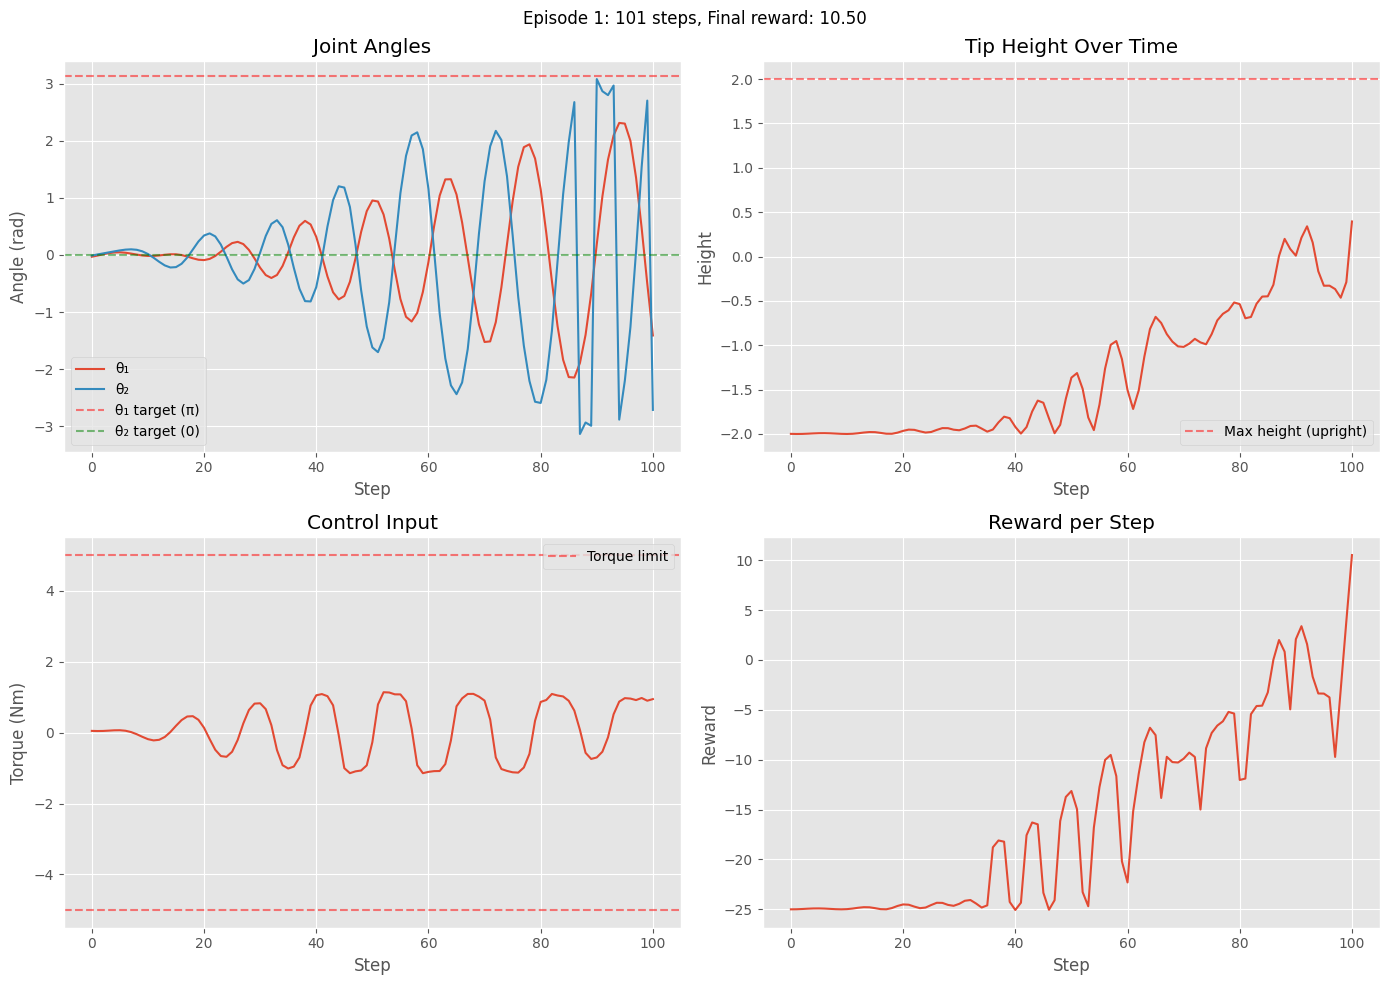

Episode 1: Steps = 101, Total reward = -1575.67


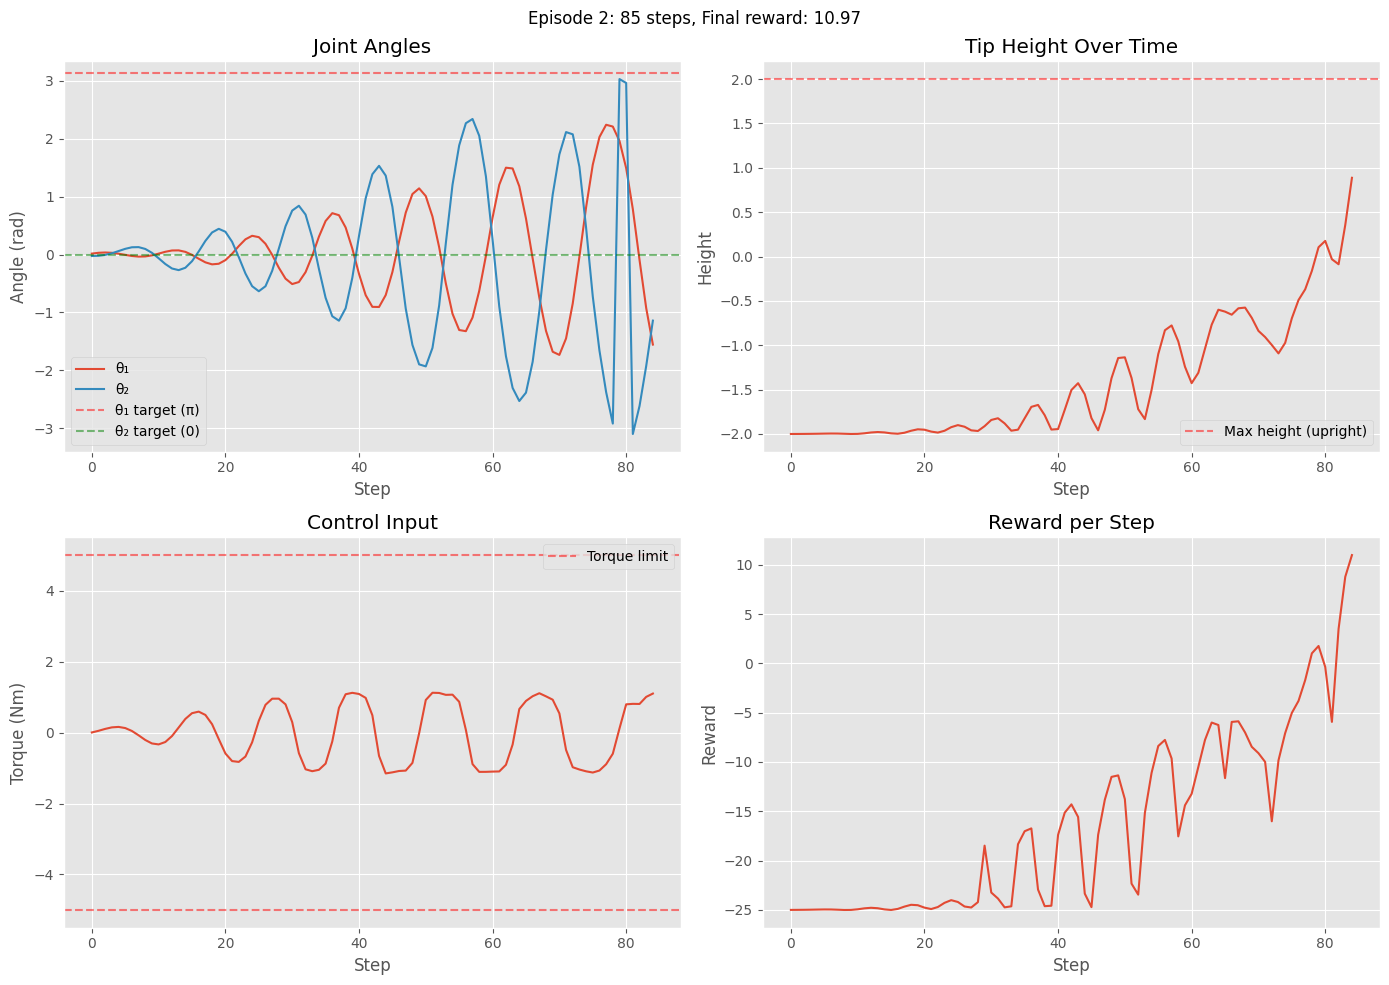

Episode 2: Steps = 85, Total reward = -1390.84


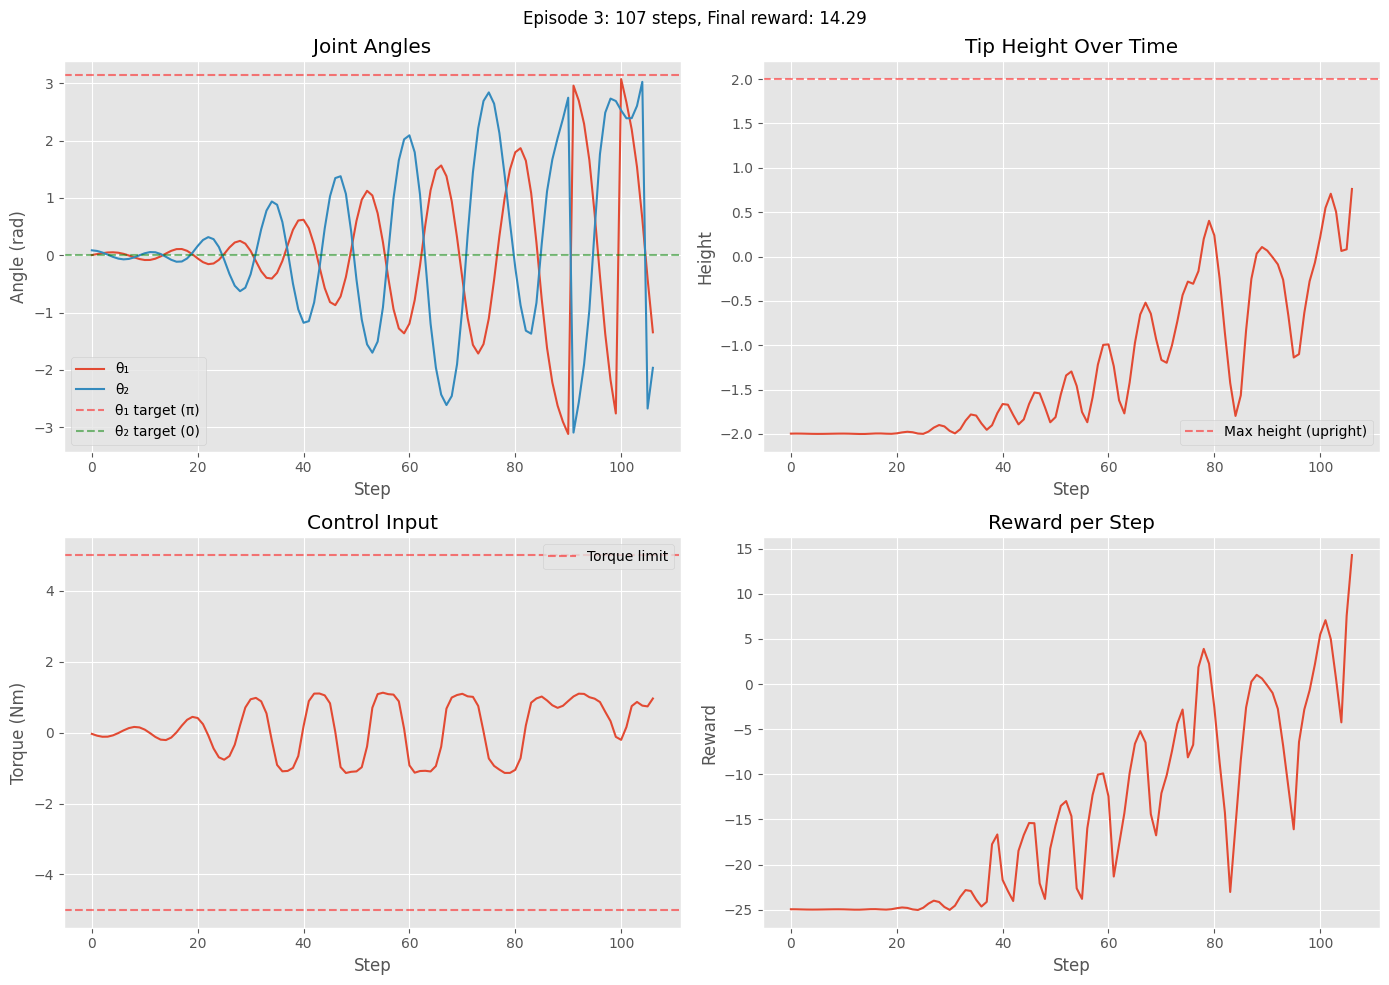

Episode 3: Steps = 107, Total reward = -1574.65


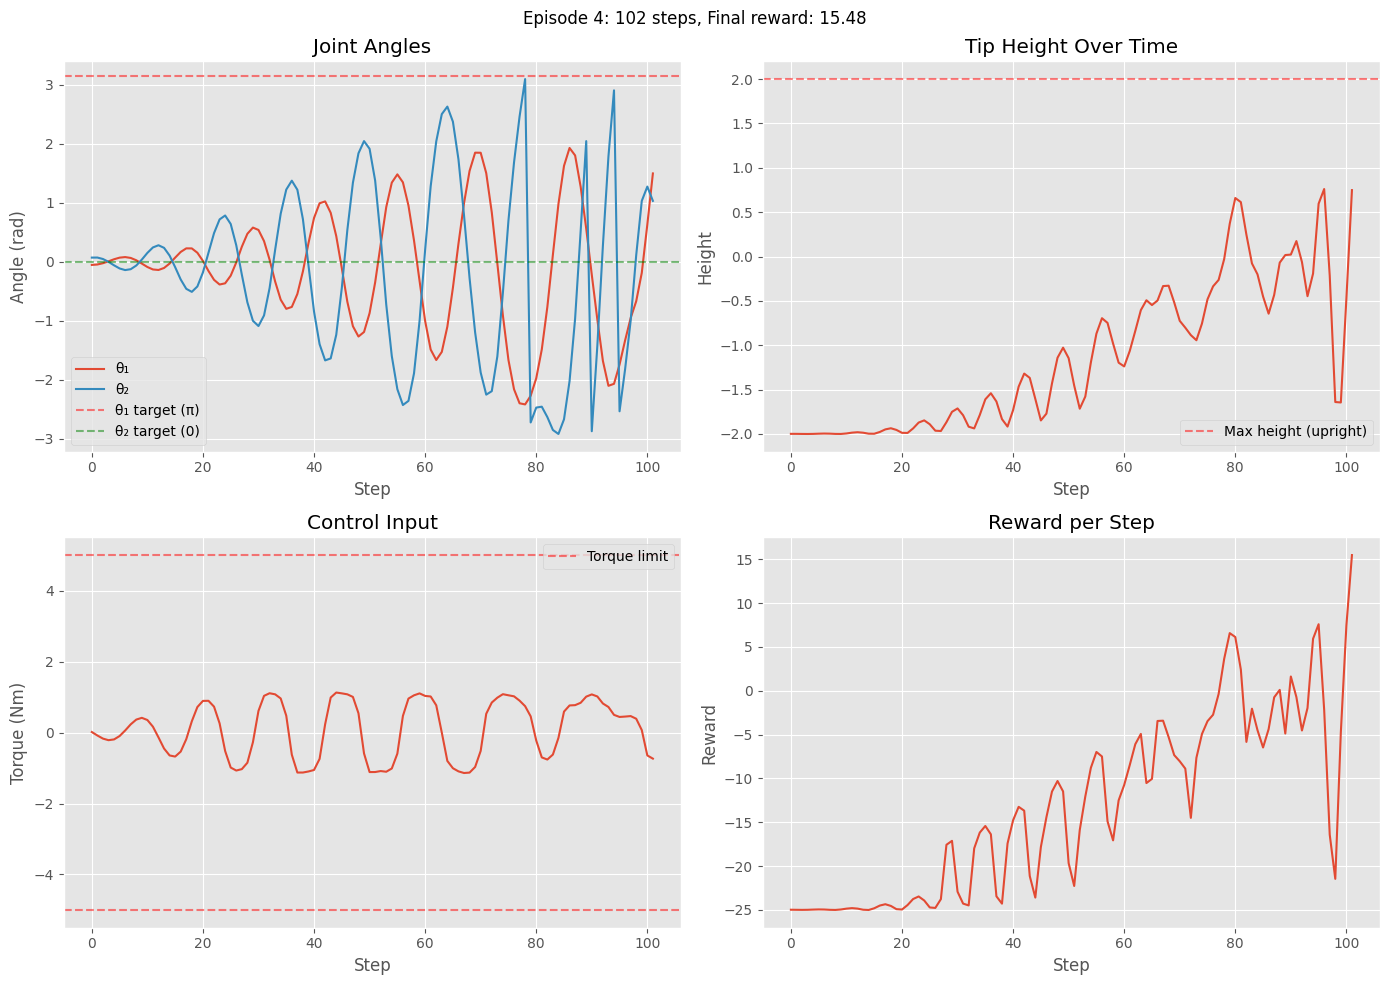

Episode 4: Steps = 102, Total reward = -1363.52


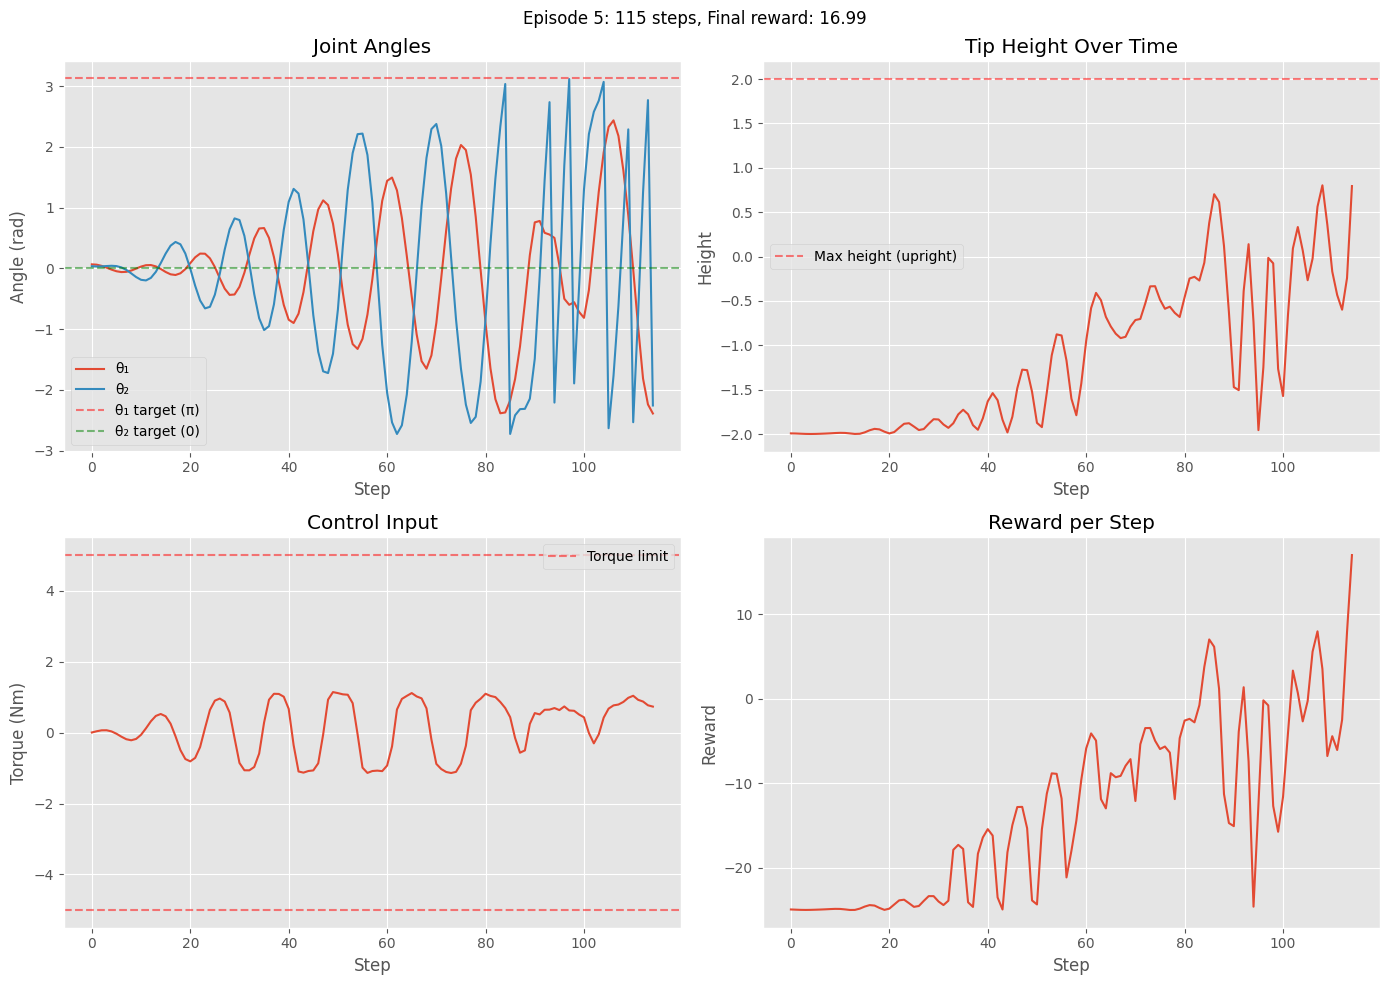

Episode 5: Steps = 115, Total reward = -1515.81


In [ ]:
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import numpy as np

# Create environment without rendering
def make_acrobot_balance_env_eval():
    base_env = gym.make("Acrobot-v1", max_episode_steps=1000)
    env = ContinuousAcrobotActionWrapper(base_env, torque_limit=5.0)
    env = AcrobotSwingUpWrapper(
        env,
        height_weight=10.0,
        control_cost=0.1,
        success_height=1.8,
        success_bonus=100.0,
        downward_penalty=5.0
    )
    return env

model = PPO.load("ppo_acrobot_swingup")
env = make_acrobot_balance_env_eval()

# Run multiple episodes and collect data
num_episodes = 5
for ep in range(num_episodes):
    obs, info = env.reset()
    done = False
    step_count = 0

    # Storage for this episode
    observations = []
    actions = []
    rewards = []

    while not done and step_count < 1000:
        action, _ = model.predict(obs, deterministic=True)
        observations.append(obs)
        actions.append(action)

        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        done = terminated or truncated
        step_count += 1

    # Convert to numpy arrays
    observations = np.array(observations)
    actions = np.array(actions)

    # Extract angles from observations
    cos_th1, sin_th1 = observations[:, 0], observations[:, 1]
    cos_th2, sin_th2 = observations[:, 2], observations[:, 3]
    th1 = np.arctan2(sin_th1, cos_th1)
    th2 = np.arctan2(sin_th2, cos_th2)

    # Calculate tip height
    height = -cos_th1 - (cos_th1 * cos_th2 - sin_th1 * sin_th2)

    # Plot results for this episode
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot angles
    axes[0, 0].plot(th1, label='θ₁')
    axes[0, 0].plot(th2, label='θ₂')
    axes[0, 0].axhline(y=np.pi, color='r', linestyle='--', alpha=0.5, label='θ₁ target (π)')
    axes[0, 0].axhline(y=0, color='g', linestyle='--', alpha=0.5, label='θ₂ target (0)')
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Angle (rad)')
    axes[0, 0].set_title('Joint Angles')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot tip height
    axes[0, 1].plot(height)
    axes[0, 1].axhline(y=2.0, color='r', linestyle='--', alpha=0.5, label='Max height (upright)')
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('Height')
    axes[0, 1].set_title('Tip Height Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot control actions
    axes[1, 0].plot(actions)
    axes[1, 0].axhline(y=5.0, color='r', linestyle='--', alpha=0.5, label='Torque limit')
    axes[1, 0].axhline(y=-5.0, color='r', linestyle='--', alpha=0.5)
    axes[1, 0].set_xlabel('Step')
    axes[1, 0].set_ylabel('Torque (Nm)')
    axes[1, 0].set_title('Control Input')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot rewards
    axes[1, 1].plot(rewards)
    axes[1, 1].set_xlabel('Step')
    axes[1, 1].set_ylabel('Reward')
    axes[1, 1].set_title('Reward per Step')
    axes[1, 1].grid(True)

    plt.suptitle(f'Episode {ep+1}: {step_count} steps, Final reward: {rewards[-1]:.2f}')
    plt.tight_layout()
    plt.show()

    print(f"Episode {ep+1}: Steps = {step_count}, Total reward = {sum(rewards):.2f}")

env.close()

### Task 5.4 - Hybrid Policy to Swing Up and then Balance (5 pts)

In this task, you need to combine two trained PPO policies: a swing-up policy and a stabilizer policy. You may refer to lab 10 for the cart pole on how to do this.

In [ ]:
#TODO: implement the missing parts

## Task 6. Discussions (5 pts)

In this Task, you will compare the **model-based control** (LQR / trajectory tracking / MPC) with the **RL-based control** on the Acrobot system. Specifically, compare the hybrid model-based controller in Task 4 vs and the hybrid RL policy generated in task 5.3 by plotting the following:
- Single comparative figure: control inputs vs time (overlay both controllers: model-based u_model(t) and RL-based u_RL(t), include legend)
- Comparative state trajectories vs time: overlay for θ₁(t), θ₂(t) showing both controllers
- Tip (end-effector) height vs time: single figure with both controllers overlaid and optionally target upright height reference line

You can choose the best policy you have obtained in RL by playing with the reward function. Based on the results you have obtained, explain the difference for the two approaches: **model-based control** vs  **RL-based control**.

---

**Submission Requirements:**
- Complete this notebook with all tasks implemented and documented.
- Written report addressing the discussion points in each task.
- Include quantitative comparisons with plots and performance metrics.
- Reflect on lessons learned about control theory and reinforcement learning.
